# Summary: 
The complete Shakya et al. dataset and subsamples of this dataset (10%, 25%, and 50%) were trimmed at quality scores of 2 and 30 using trimmomatic and classified with sourmash gather.All sourmash signatures were calculated with --scaled values of 10000, k values of 21, 31 and 51, and abundance tracking. Classifiication was performed with both genbank and refseq databases created in may of 2017.

The data used in this notebook is  stored on the open science framework 
(https://osf.io/dm938/) in the taxonomic_classification/sourmash directory. 


# Example Use Case:
In this example, the complete Shakya et al. 2013 metagenome is being compared to small, medium, and large subsamples of itself after conservative or aggressive read filtering. The datasets used in this example are named according to their metagenome content and relative degree of read filtering:

* SRR606249 = Accession number for the complete Shakya et al. 2013 metagenome
* subset50 = 50% of the complete Shakya et al. 2013 metagenome
* subset25 = 25% of the complete Shakya et al. 2013 metagenome
* subset10 = 10% of the complete Shakya et al. 2013 metagenome
* pe.trim2 = Conservative read filtering
* pe.trim30 = Aggressive read filtering
* megahit = MEGHIT assembly 
* spades = SPAdes assembly 


# Objectives:

* To determine how both conservative and aggresive quality trimming of reads affects classification results 
* To determine what fraction of the dataset is required to detect all these genomes
* To compare resutls of taxonomic classification from reads and contigs

In [1]:
from taxa import *

In [2]:
combined_df = concat_sourmash_csv("*k51.gather.output.csv")

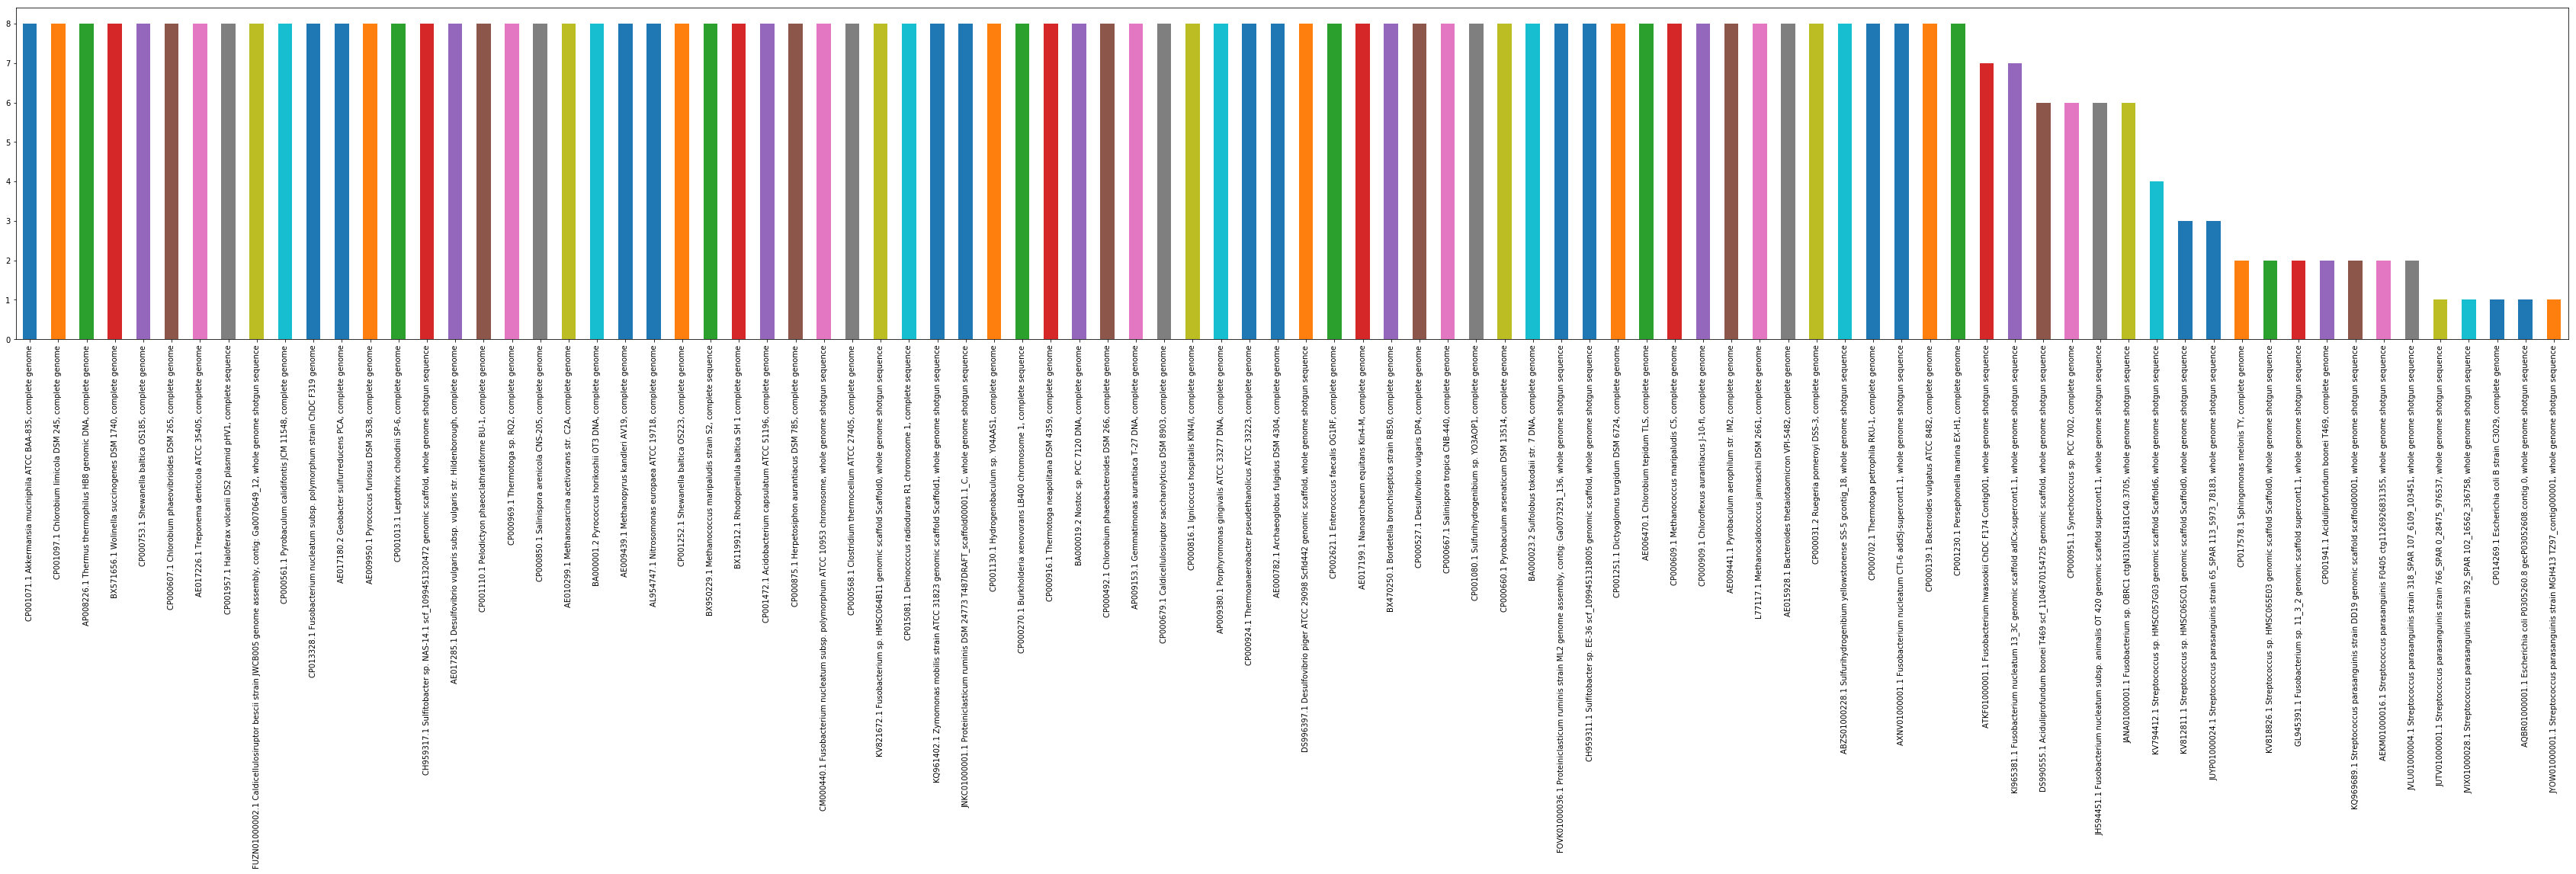

In [3]:
# Visual representation of all of the OTUs detected at in the complete and subsampled datasets,
# and k values of pof 
plot_otu_presence_absence("*k51.gather.output.csv")

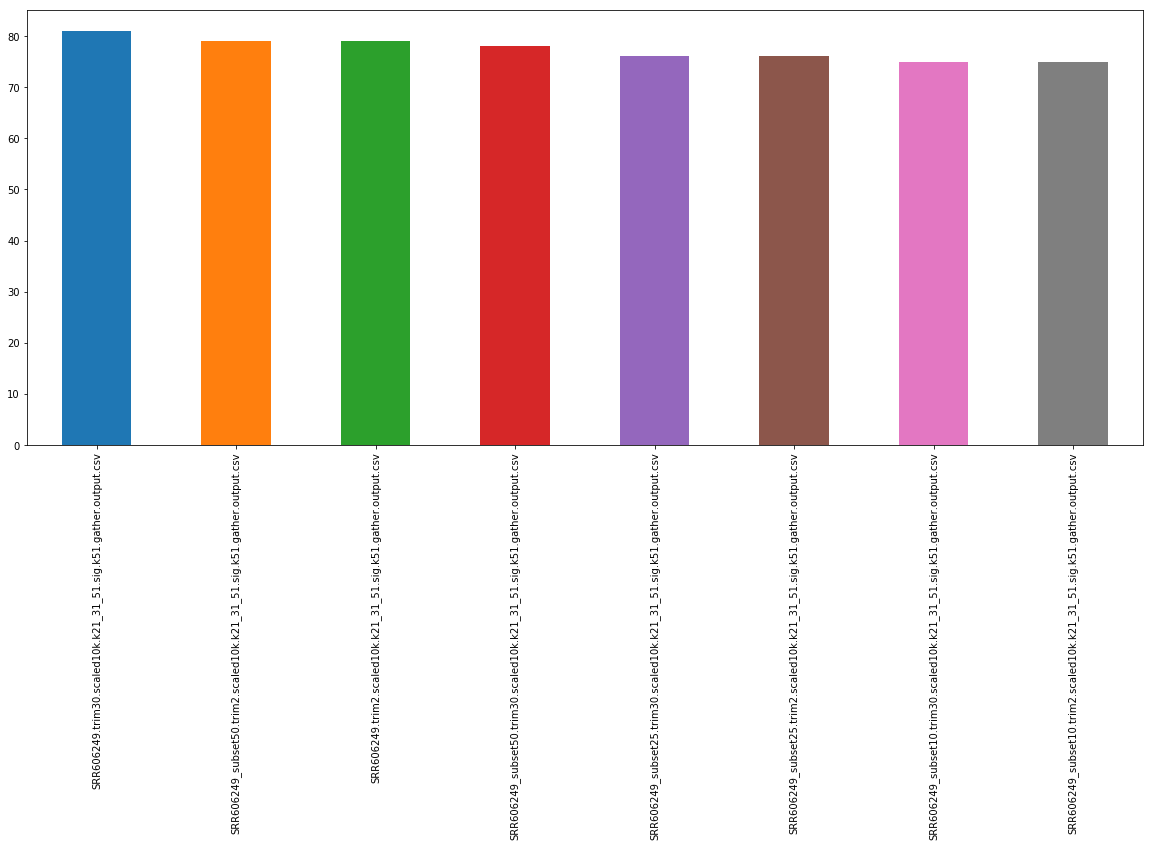

In [4]:
combined_df['filename'].value_counts().plot(kind="bar", figsize = (20,8))

In [16]:
def create_sourmash_presence_absence_table(filenames):
    # Creat concatenated tsv file 
    combined_df = concat_sourmash_csv(filenames)
    # Remove columns keeping only 'gene' and 'filename'
    # Drop any na values
    #x = combined_df.dropna(axis=0, inplace=True)
    g = combined_df.groupby('name')
    ug = list(set(combined_df['name']))

    a = []
    for name in ug:
        gene_group = g.get_group(name)
        if len(gene_group['filename'])>1:
            a.append(gene_group[['filename', 'name']])

    from collections import defaultdict
    gene_filenames = defaultdict(list)

    for line in a:
       gene_filenames[line['name'].iloc[0]].extend(line['filename'].tolist())
    
    filenames = set()
    for files in gene_filenames.values():
        filenames.update(files)

    filenames = list(filenames)
    data = {}
    for name, files in gene_filenames.items():
        data[name] = [file in files for file in filenames]
    dense_df = pd.DataFrame.from_dict(data, orient='index', columns=filenames)
    return dense_df
create_sourmash_presence_absence_table("*k51.gather.output.csv")

,SRR606249_subset10.trim2.scaled10k.k21_31_51.sig.k51.gather.output.csv,SRR606249_subset10.trim30.scaled10k.k21_31_51.sig.k51.gather.output.csv,SRR606249_subset50.trim30.scaled10k.k21_31_51.sig.k51.gather.output.csv,SRR606249.trim2.scaled10k.k21_31_51.sig.k51.gather.output.csv,SRR606249_subset25.trim30.scaled10k.k21_31_51.sig.k51.gather.output.csv,SRR606249_subset50.trim2.scaled10k.k21_31_51.sig.k51.gather.output.csv,SRR606249.trim30.scaled10k.k21_31_51.sig.k51.gather.output.csv,SRR606249_subset25.trim2.scaled10k.k21_31_51.sig.k51.gather.output.csv
"KQ969689.1 Streptococcus parasanguinis strain DD19 genomic scaffold scaffold00001, whole genome shotgun sequence",False,False,False,True,False,False,True,False
"CM000440.1 Fusobacterium nucleatum subsp. polymorphum ATCC 10953 chromosome, whole genome shotgun sequence",True,True,True,True,True,True,True,True
"KQ961402.1 Zymomonas mobilis strain ATCC 31823 genomic scaffold Scaffold1, whole genome shotgun sequence",True,True,True,True,True,True,True,True
"AE017180.2 Geobacter sulfurreducens PCA, complete genome",True,True,True,True,True,True,True,True
"ATKF01000001.1 Fusobacterium hwasookii ChDC F174 Contig001, whole genome shotgun sequence",True,True,True,False,True,True,True,True
CP013328.1 Fusobacterium nucleatum subsp. polymorphum strain ChDC F319 genome,True,True,True,True,True,True,True,True
"AP009380.1 Porphyromonas gingivalis ATCC 33277 DNA, complete genome",True,True,True,True,True,True,True,True
"ABZS01000228.1 Sulfurihydrogenibium yellowstonense SS-5 gcontig_18, whole genome shotgun sequence",True,True,True,True,True,True,True,True
"CP000561.1 Pyrobaculum calidifontis JCM 11548, complete genome",True,True,True,True,True,True,True,True
"AE009950.1 Pyrococcus furiosus DSM 3638, complete genome",True,True,True,True,True,True,True,True


In [6]:
# create new dataframe with name a file_name columns
new = df[['name', 'file_name']].copy()

#create empty dataframe 
results = pd.DataFrame()
# Put names from dataframe new column "name" in resutls column name 
results['name'] = new['name']
for col in new['file_name'].unique():
    results[col] = ((col == new['file_name'])
    .astype(object)
    .replace(True, 1)
    .replace(False, 0))
results = results.groupby('name').agg(sum).reset_index()
results.to_csv('results.csv')

# Combined genus and species in a new column genus_species
# First, make new columns with the second(genus) and third(species) fields from 
# the column 'name" in dataframe 'new'
new['genus'] = new['name'].str.split(' ').str[1]
#new['species'] = new['name'].str.split(' ').str[2]
# Combined the columns 'genus' and 'species' with a space in between
#new["genus_species"] = new["genus"].map(str) +[" "] + new["species"]
#Write the new df to a csv named 'new2.csv'
new.to_csv('new2.csv')
# Print new
#new

NameError: name 'df' is not defined

In [7]:
#Create an empty dataframe 
results2 = pd.DataFrame()
# Put names from dataframe new column "name" in resutls column name 
results2['genus'] = new['genus']
for col in new['file_name'].unique():
    results2[col] = ((col == new['file_name'])
    .astype(object)
    .replace(True, 1)
    .replace(False, 0))
results2 = results2.groupby('genus').agg(sum).reset_index()
results2.loc[results2["SRR606249_subset10.trim2.scaled10k.k21_31_51.sig.k51"] > 0, 'SRR606249_subset10.trim2.scaled10k.k21_31_51.sig.k51'] = 1
results2.loc[results2["SRR606249_subset50.trim30.scaled10k.k21_31_51.sig.k51"] > 0, 'SRR606249_subset50.trim30.scaled10k.k21_31_51.sig.k51'] = 1
results2.loc[results2["SRR606249_subset50.trim2.scaled10k.k21_31_51.sig.k51"] > 0, 'SRR606249_subset50.trim2.scaled10k.k21_31_51.sig.k51'] = 1
results2.loc[results2["SRR606249_subset10.trim30.scaled10k.k21_31_51.sig.k31"] > 0, 'SRR606249_subset10.trim30.scaled10k.k21_31_51.sig.k31'] = 1
results2.loc[results2["SRR606249_subset25.trim30.scaled10k.k21_31_51.sig.k31"] > 0, 'SRR606249_subset25.trim30.scaled10k.k21_31_51.sig.k31'] = 1
results2.loc[results2["SRR606249.trim2.scaled10k.k21_31_51.sig.k21"] > 0, 'SRR606249.trim2.scaled10k.k21_31_51.sig.k21'] = 1
results2.loc[results2["SRR606249_subset25.trim2.scaled10k.k21_31_51.sig.k31"] > 0, 'SRR606249_subset25.trim2.scaled10k.k21_31_51.sig.k31'] = 1
results2.loc[results2["SRR606249_subset25.trim30.scaled10k.k21_31_51.sig.k51"] > 0, 'SRR606249_subset25.trim30.scaled10k.k21_31_51.sig.k51'] = 1
results2.loc[results2["SRR606249_subset25.trim2.scaled10k.k21_31_51.sig.k51"] > 0, 'SRR606249_subset25.trim2.scaled10k.k21_31_51.sig.k51'] = 1
results2.loc[results2["SRR606249_subset10.trim30.scaled10k.k21_31_51.sig.k51"] > 0, 'SRR606249_subset10.trim30.scaled10k.k21_31_51.sig.k51'] = 1
results2.loc[results2["SRR606249_subset50.trim2.scaled10k.k21_31_51.sig.k31"] > 0, 'SRR606249_subset50.trim2.scaled10k.k21_31_51.sig.k31'] = 1
results2.loc[results2["SRR606249_subset50.trim30.scaled10k.k21_31_51.sig.k31"] > 0, 'SRR606249_subset50.trim30.scaled10k.k21_31_51.sig.k31'] = 1
results2.loc[results2["SRR606249.trim30.scaled10k.k21_31_51.sig.k21"] > 0, 'SRR606249.trim30.scaled10k.k21_31_51.sig.k21'] = 1
results2.loc[results2["SRR606249_subset10.trim2.scaled10k.k21_31_51.sig.k31"] > 0, 'SRR606249_subset10.trim2.scaled10k.k21_31_51.sig.k31'] = 1
results2.loc[results2["SRR606249_subset50.trim30.scaled10k.k21_31_51.sig.k21"] > 0, 'SRR606249_subset50.trim30.scaled10k.k21_31_51.sig.k21'] = 1
results2.loc[results2["SRR606249_subset10.trim2.scaled10k.k21_31_51.sig.k21"] > 0, 'SRR606249_subset10.trim2.scaled10k.k21_31_51.sig.k21'] = 1
results2.loc[results2["SRR606249.trim30.scaled10k.k21_31_51.sig.k31"] > 0, 'SRR606249.trim30.scaled10k.k21_31_51.sig.k31'] = 1
results2.loc[results2["SRR606249.trim2.scaled10k.k21_31_51.sig.k51"] > 0, 'SRR606249.trim2.scaled10k.k21_31_51.sig.k51'] = 1
results2.loc[results2["SRR606249_subset50.trim2.scaled10k.k21_31_51.sig.k21"] > 0, 'SRR606249_subset50.trim2.scaled10k.k21_31_51.sig.k21'] = 1
results2.loc[results2["SRR606249_subset10.trim30.scaled10k.k21_31_51.sig.k21"] > 0, 'SRR606249_subset10.trim30.scaled10k.k21_31_51.sig.k21'] = 1
results2.loc[results2["SRR606249_subset25.trim2.scaled10k.k21_31_51.sig.k21"] > 0, 'SRR606249_subset25.trim2.scaled10k.k21_31_51.sig.k21'] = 1
results2.loc[results2["SRR606249.trim2.scaled10k.k21_31_51.sig.k31"] > 0, 'SRR606249.trim2.scaled10k.k21_31_51.sig.k31'] = 1
results2.loc[results2["SRR606249_subset25.trim30.scaled10k.k21_31_51.sig.k21"] > 0, 'SRR606249_subset25.trim30.scaled10k.k21_31_51.sig.k21'] = 1
results2.loc[results2["SRR606249.trim30.scaled10k.k21_31_51.sig.k51"] > 0, 'SRR606249.trim30.scaled10k.k21_31_51.sig.k51'] = 1

results2.to_csv('results2.csv')
#results2

NameError: name 'new' is not defined

In [8]:
df_complete_copy = df_complete[['name', 'file_name']].copy()
#create empty dataframe 
results = pd.DataFrame()
# Put names from dataframe new column "name" in resutls column name 
results['name'] = df_complete_copy['name']
for col in df_complete_copy['file_name'].unique():
    results[col] = ((col == df_complete_copy['file_name'])
    .astype(object)
    .replace(True, 1)
    .replace(False, 0))
results = results.groupby('name').agg(sum).reset_index()
results.to_csv('results3.csv')

df_complete_copy['genus'] = df_complete_copy['name'].str.split(' ').str[1]

#Create an empty dataframe 
results_complete = pd.DataFrame()
# Put names from dataframe new column "name" in resutls column name 
results_complete['genus'] = df_complete_copy['genus']
for col in df_complete_copy['file_name'].unique():
    results_complete[col] = ((col == df_complete_copy['file_name'])
    .astype(object)
    .replace(True, 1)
    .replace(False, 0))
results_complete = results_complete.groupby('genus').agg(sum).reset_index()



results_complete.loc[results_complete["SRR606249.trim2.scaled10k.k21_31_51.sig.k21"] > 0, 'SRR606249.trim2.scaled10k.k21_31_51.sig.k21'] = 1
results_complete.loc[results_complete["SRR606249.trim30.scaled10k.k21_31_51.sig.k21"] > 0, 'SRR606249.trim30.scaled10k.k21_31_51.sig.k21'] = 1
results_complete.loc[results_complete["SRR606249.trim30.scaled10k.k21_31_51.sig.k31"] > 0, 'SRR606249.trim30.scaled10k.k21_31_51.sig.k31'] = 1
results_complete.loc[results_complete["SRR606249.trim2.scaled10k.k21_31_51.sig.k51"] > 0, 'SRR606249.trim2.scaled10k.k21_31_51.sig.k51'] = 1
results_complete.loc[results_complete["SRR606249.trim2.scaled10k.k21_31_51.sig.k31"] > 0, 'SRR606249.trim2.scaled10k.k21_31_51.sig.k31'] = 1
results_complete.loc[results_complete["SRR606249.trim30.scaled10k.k21_31_51.sig.k51"] > 0, 'SRR606249.trim30.scaled10k.k21_31_51.sig.k51'] = 1

results_complete.to_csv('results3.csv')
results_complete

NameError: name 'df_complete' is not defined

### Change kernel to R 

In [6]:
gather <- read.csv("results.csv", header = T, sep = ",")
#Print gather 
gather

X,name,SRR606249_subset10.trim2.scaled10k.k21_31_51.sig.k51,SRR606249_subset50.trim30.scaled10k.k21_31_51.sig.k51,SRR606249_subset50.trim2.scaled10k.k21_31_51.sig.k51,SRR606249_subset10.trim30.scaled10k.k21_31_51.sig.k31,SRR606249_subset25.trim30.scaled10k.k21_31_51.sig.k31,SRR606249.trim2.scaled10k.k21_31_51.sig.k21,SRR606249_subset25.trim2.scaled10k.k21_31_51.sig.k31,SRR606249_subset25.trim30.scaled10k.k21_31_51.sig.k51,⋯,SRR606249_subset50.trim30.scaled10k.k21_31_51.sig.k21,SRR606249_subset10.trim2.scaled10k.k21_31_51.sig.k21,SRR606249.trim30.scaled10k.k21_31_51.sig.k31,SRR606249.trim2.scaled10k.k21_31_51.sig.k51,SRR606249_subset50.trim2.scaled10k.k21_31_51.sig.k21,SRR606249_subset10.trim30.scaled10k.k21_31_51.sig.k21,SRR606249_subset25.trim2.scaled10k.k21_31_51.sig.k21,SRR606249.trim2.scaled10k.k21_31_51.sig.k31,SRR606249_subset25.trim30.scaled10k.k21_31_51.sig.k21,SRR606249.trim30.scaled10k.k21_31_51.sig.k51
0,"ABZS01000228.1 Sulfurihydrogenibium yellowstonense SS-5 gcontig_18, whole genome shotgun sequence",1,1,1,1,1,1,1,1,⋯,1,1,1,1,1,1,1,1,1,1
1,"AE000782.1 Archaeoglobus fulgidus DSM 4304, complete genome",1,1,1,1,1,1,1,1,⋯,1,1,1,1,1,1,1,1,1,1
2,"AE005673.1 Caulobacter crescentus CB15, complete genome",0,0,0,0,0,1,0,0,⋯,0,0,0,0,0,0,0,0,0,0
3,"AE006470.1 Chlorobium tepidum TLS, complete genome",1,1,1,1,1,1,1,1,⋯,1,1,1,1,1,1,1,1,1,1
4,"AE008691.1 Thermoanaerobacter tengcongensis MB4, complete genome",0,0,0,0,0,0,0,0,⋯,0,0,0,0,0,0,0,1,0,0
5,"AE009439.1 Methanopyrus kandleri AV19, complete genome",1,1,1,1,1,1,1,1,⋯,1,1,1,1,1,1,1,1,1,1
6,"AE009441.1 Pyrobaculum aerophilum str. IM2, complete genome",1,1,1,1,1,1,1,1,⋯,1,1,1,1,1,1,1,1,1,1
7,"AE009950.1 Pyrococcus furiosus DSM 3638, complete genome",1,1,1,1,1,1,1,1,⋯,1,1,1,1,1,1,1,1,1,1
8,"AE010299.1 Methanosarcina acetivorans str. C2A, complete genome",1,1,1,1,1,1,1,1,⋯,1,1,1,1,1,1,1,1,1,1
9,"AE015928.1 Bacteroides thetaiotaomicron VPI-5482, complete genome",1,1,1,1,1,1,1,1,⋯,1,1,1,1,1,1,1,1,1,1


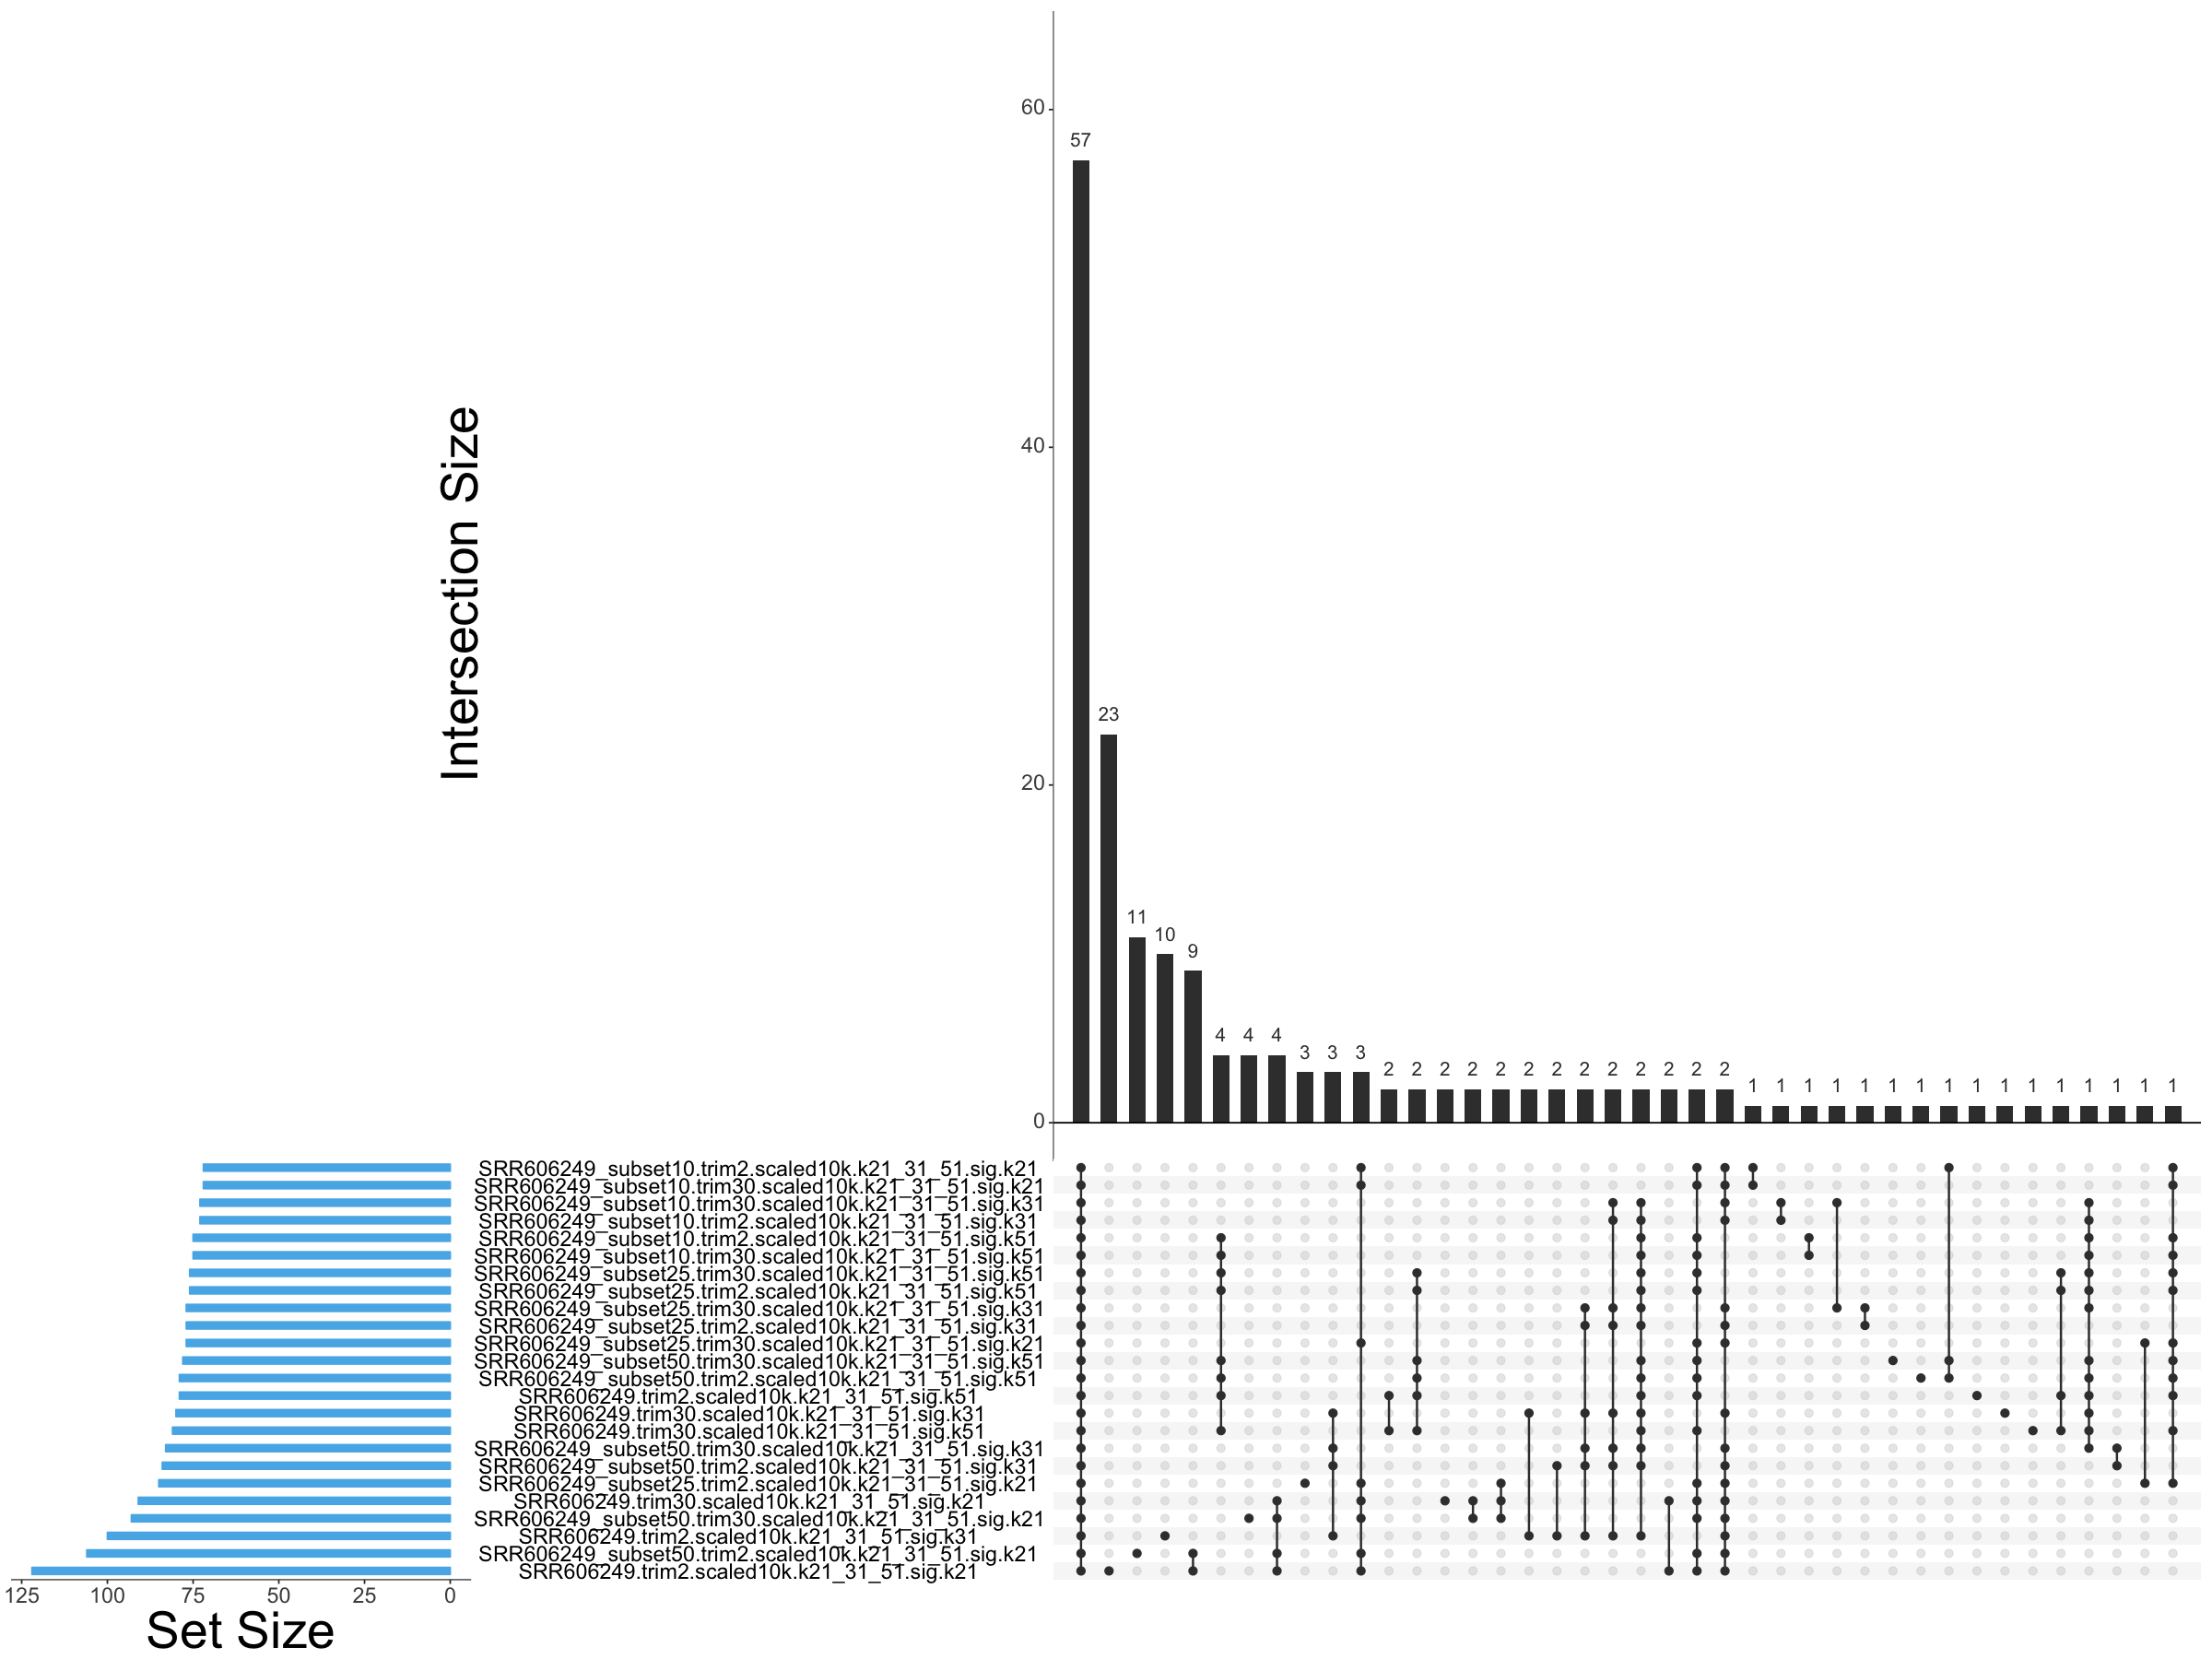

In [8]:
library(UpSetR)
#Change plot size to 20X20
options(repr.plot.width=20, repr.plot.height=15)
upset(gather, nsets = 24, sets.bar.color = "#56B4E9", order.by = "freq", 
      text.scale = c(4, 2, 4, 2, 2, 2))

In [2]:
gather2 <- read.csv("results2.csv", header = T, sep = ",")
#Print gather 2 
gather2

X,genus,SRR606249_subset10.trim2.scaled10k.k21_31_51.sig.k51,SRR606249_subset50.trim30.scaled10k.k21_31_51.sig.k51,SRR606249_subset50.trim2.scaled10k.k21_31_51.sig.k51,SRR606249_subset10.trim30.scaled10k.k21_31_51.sig.k31,SRR606249_subset25.trim30.scaled10k.k21_31_51.sig.k31,SRR606249.trim2.scaled10k.k21_31_51.sig.k21,SRR606249_subset25.trim2.scaled10k.k21_31_51.sig.k31,SRR606249_subset25.trim30.scaled10k.k21_31_51.sig.k51,⋯,SRR606249_subset50.trim30.scaled10k.k21_31_51.sig.k21,SRR606249_subset10.trim2.scaled10k.k21_31_51.sig.k21,SRR606249.trim30.scaled10k.k21_31_51.sig.k31,SRR606249.trim2.scaled10k.k21_31_51.sig.k51,SRR606249_subset50.trim2.scaled10k.k21_31_51.sig.k21,SRR606249_subset10.trim30.scaled10k.k21_31_51.sig.k21,SRR606249_subset25.trim2.scaled10k.k21_31_51.sig.k21,SRR606249.trim2.scaled10k.k21_31_51.sig.k31,SRR606249_subset25.trim30.scaled10k.k21_31_51.sig.k21,SRR606249.trim30.scaled10k.k21_31_51.sig.k51
0,Acanthamoeba,0,0,0,0,0,1,0,0,⋯,0,0,0,0,0,0,0,0,0,0
1,Acidobacterium,1,1,1,1,1,1,1,1,⋯,1,1,1,1,1,1,1,1,1,1
2,Acidovorax,0,0,0,0,0,0,0,0,⋯,0,0,0,0,1,0,0,0,0,0
3,Aciduliprofundum,1,1,1,1,1,1,1,1,⋯,1,1,1,1,1,1,1,1,1,1
4,Akkermansia,1,1,1,1,1,1,1,1,⋯,1,1,1,1,1,1,1,1,1,1
5,Alloactinosynnema,0,0,0,0,0,1,0,0,⋯,0,0,0,0,0,0,0,0,0,0
6,Archaeoglobus,1,1,1,1,1,1,1,1,⋯,1,1,1,1,1,1,1,1,1,1
7,Archangium,0,0,0,0,0,1,0,0,⋯,0,0,0,0,1,0,0,0,0,0
8,Aspergillus,0,0,0,0,0,1,0,0,⋯,0,0,0,0,0,0,0,0,0,0
9,Azohydromonas,0,0,0,0,0,0,0,0,⋯,0,0,0,0,1,0,0,0,0,0


In [9]:
library(UpSetR)
#Change plot size to 20X20
options(repr.plot.width=10, repr.plot.height=5)
png("mygraph.png")
upset(gather2, nsets= 24, sets.bar.color = "#56B4E9", order.by = "freq", text.scale = c(1.3, 1.3, 1, 1, 2, 0.75))
dev.off()

pdf 
  2

In [4]:
gather3 <- read.csv("results3.csv", header = T, sep = ",")
#Print gather 
gather3

X,genus,SRR606249.trim2.scaled10k.k21_31_51.sig.k21,SRR606249.trim30.scaled10k.k21_31_51.sig.k21,SRR606249.trim30.scaled10k.k21_31_51.sig.k31,SRR606249.trim2.scaled10k.k21_31_51.sig.k51,SRR606249.trim2.scaled10k.k21_31_51.sig.k31,SRR606249.trim30.scaled10k.k21_31_51.sig.k51
0,Acanthamoeba,1,0,0,0,0,0
1,Acidobacterium,1,1,1,1,1,1
2,Aciduliprofundum,1,1,1,1,1,1
3,Akkermansia,1,1,1,1,1,1
4,Alloactinosynnema,1,0,0,0,0,0
5,Archaeoglobus,1,1,1,1,1,1
6,Archangium,1,0,0,0,0,0
7,Aspergillus,1,0,0,0,0,0
8,Bacteroides,1,1,1,1,1,1
9,Bordetella,1,1,1,1,1,1


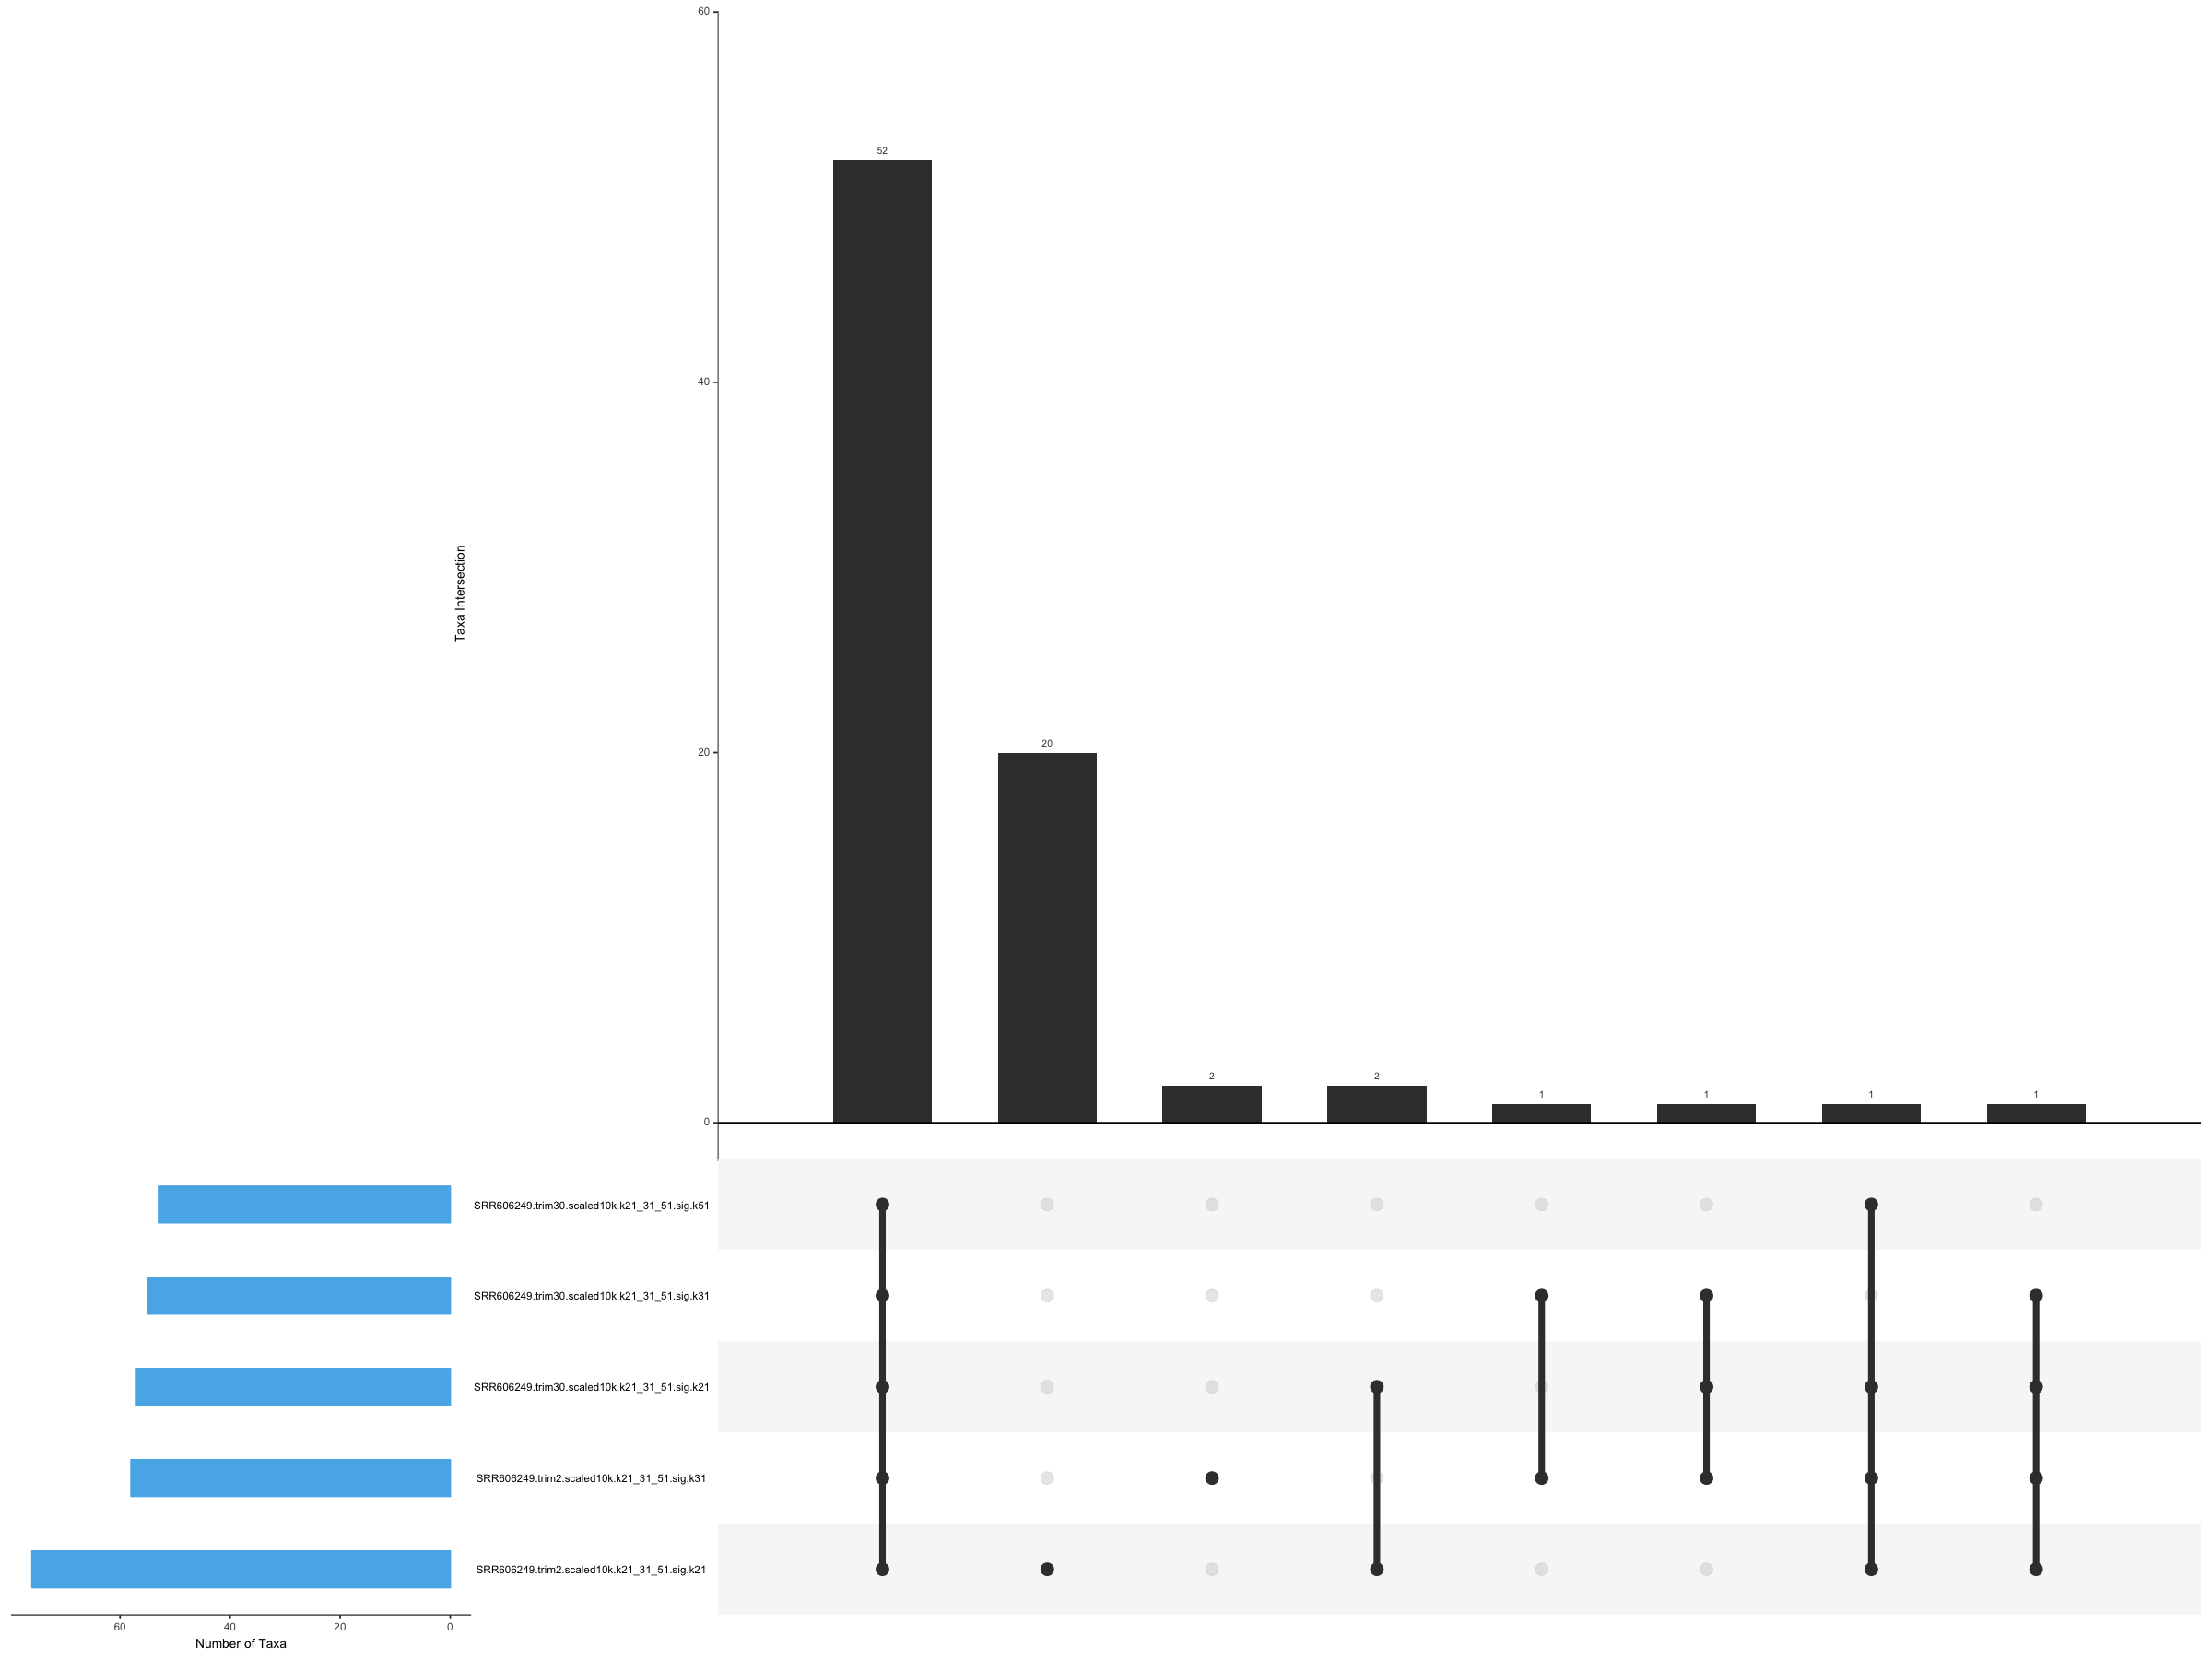

In [5]:
library(UpSetR)
#Change plot size to 20X20
options(repr.plot.width=20, repr.plot.height=15)
upset(gather3, ncol = sets.bar.color = "#56B4E9", order.by = "freq",  point.size = 3.5, line.size = 2, 
      mainbar.y.label = "Taxa Intersection", 
      sets.x.label = "Number of Taxa",)
      #text.scale = c(4, 2, 4, 2, 2, 4))